In this Colab, we will use a keras Long Short-Term Memory (LSTM) model to predict the stock price of Tata Global Beverages


Here are some imports we need to make: numpy for scientific computation, matplotlib for graphing, and pandas for manipulating data.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

Load training data set with the "Open" and "High" columns to use in our modeling.

In [6]:
url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv'
dataset_train = pd.read_csv(url)
training_set = dataset_train.iloc[:, 1:2].values

Let's take a look at the first five rows of our dataset

Import MinMaxScaler from scikit-learn to scale our dataset into numbers between 0 and 1

In [5]:
df = pd.read_csv('GBPUSD1440.csv',delimiter=',')
df.columns =['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Time,Open,High,Low,Close,Volume
0,2016.11.23,00:00,1.24212,1.24671,1.23587,1.24252,61588
1,2016.11.24,00:00,1.24250,1.24928,1.24003,1.24497,53849
2,2016.11.25,00:00,1.24494,1.24800,1.24139,1.24738,61200
3,2016.11.27,00:00,1.24585,1.24799,1.24482,1.24782,1941
4,2016.11.28,00:00,1.24781,1.25296,1.23839,1.24064,63375


In [14]:
df.iloc[:, 2:-1].astype('Float64')

,Open,High,Low,Close,Volume
0,1.24212,1.24671,1.23587,1.24252,61588.0
1,1.2425,1.24928,1.24003,1.24497,53849.0
2,1.24494,1.248,1.24139,1.24738,61200.0
3,1.24585,1.24799,1.24482,1.24782,1941.0
4,1.24781,1.25296,1.23839,1.24064,63375.0
...,...,...,...,...,...
2043,1.25792,1.2599,1.24864,1.2514,39154.0
2044,1.25139,1.26242,1.25128,1.26059,49789.0
2045,1.26058,1.26985,1.26001,1.26702,50186.0
2046,1.26703,1.279,1.26291,1.27841,50135.0


In [25]:
# df['avg'] = df.loc[:, ['Open', 'High', 'Low', 'Close']].sum(axis=1)/4.0
df['avg'] = (df['Low']+df['High']+df['Open'] + df['Close'])/4


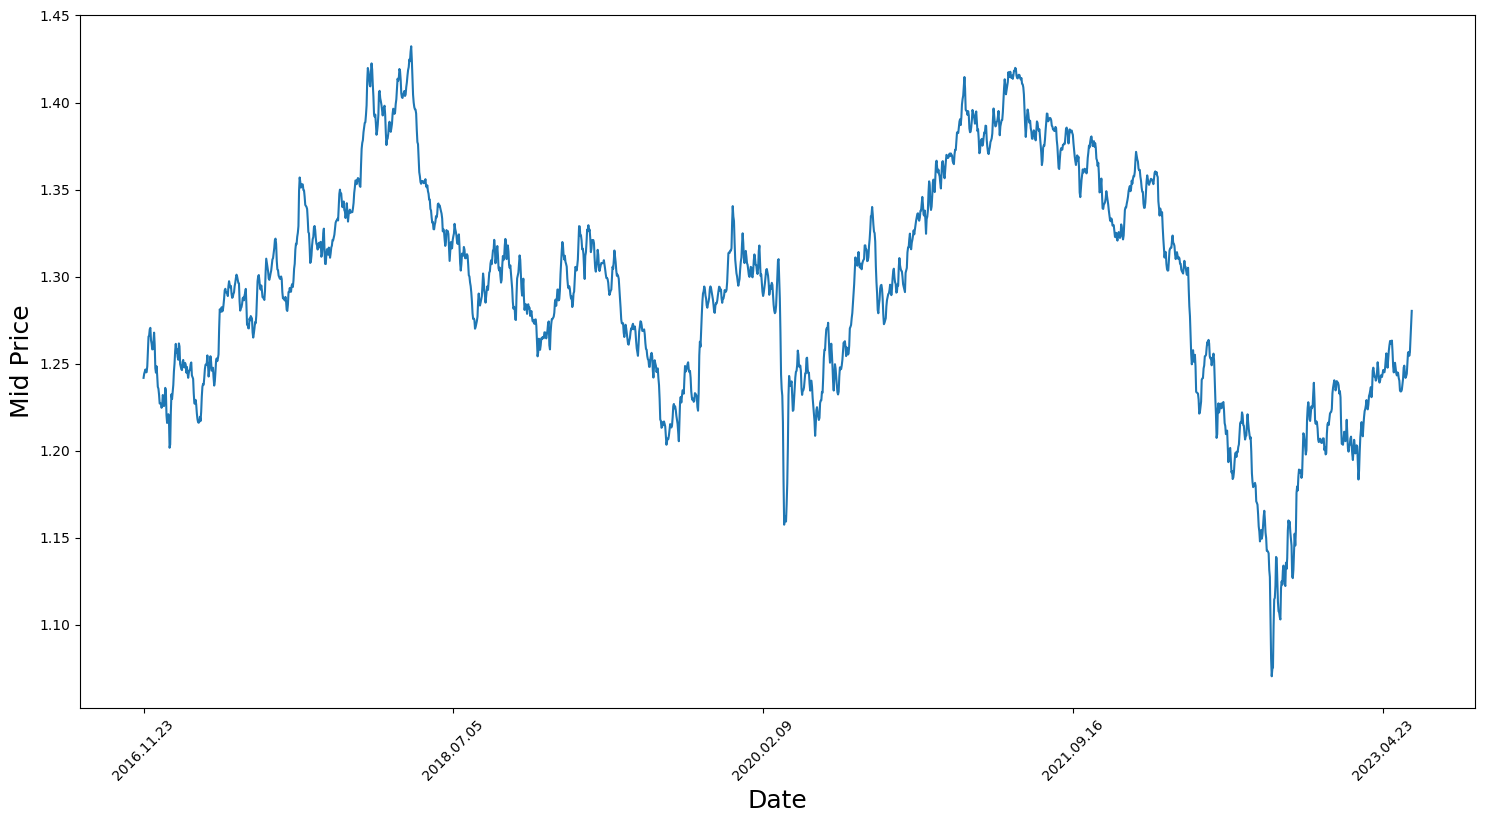

In [26]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),df['avg'])
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [27]:
sc = MinMaxScaler(feature_range=(0,1))
total_dataset_scaled = sc.fit_transform(df.avg.values.reshape(-1, 1))

In [18]:
total_dataset_scaled.shape

(2048, 1)

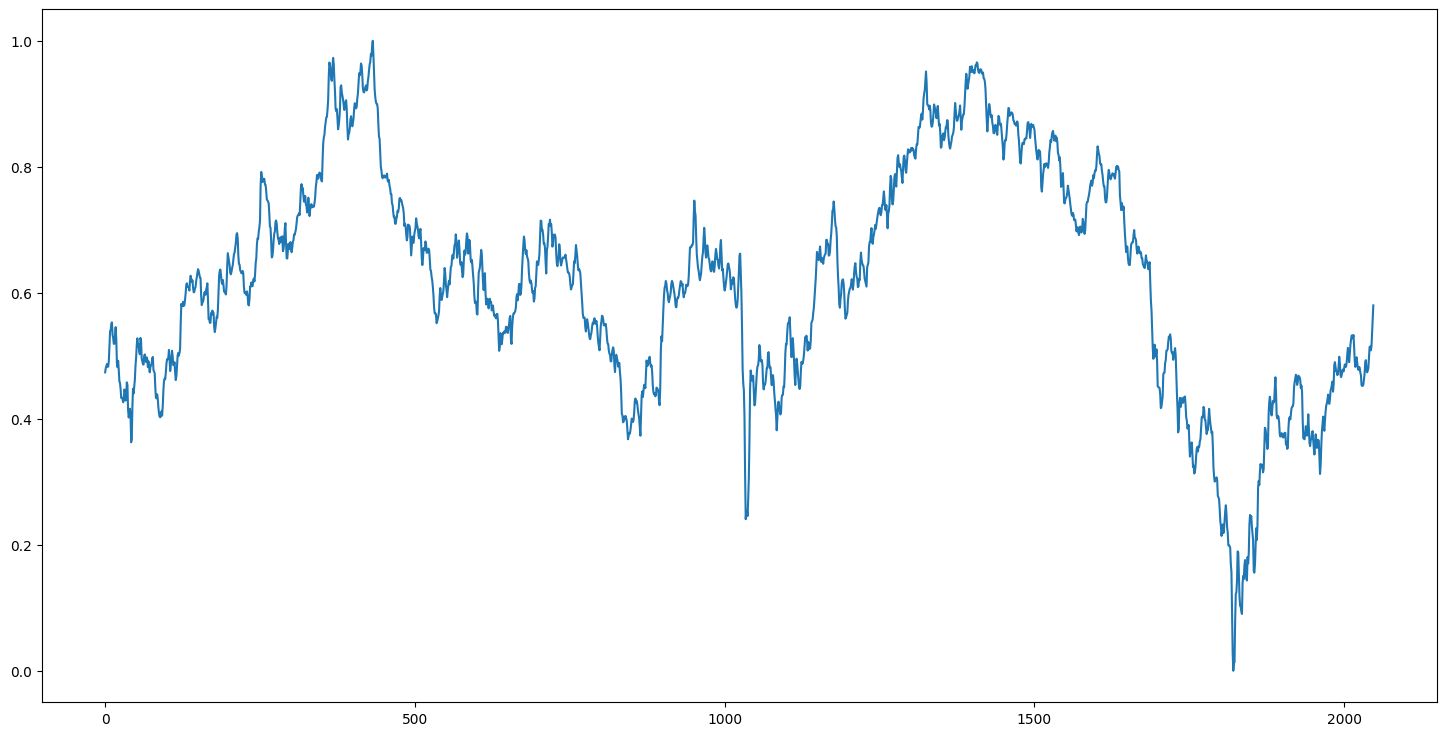

In [29]:
plt.figure(figsize = (18,9))
plt.plot(total_dataset_scaled)

We want our data to be in the form of a 3D array for our LSTM model. First, we create data in 60 timesteps and convert it into an array using NumPy. Then, we convert the data into a 3D array with X_train samples, 60 timestamps, and one feature at each step.

In [30]:
# Split the data into training and testing sets
train_size = int(len(total_dataset_scaled) * 0.9)
training_set_scaled, test_set_scaled = total_dataset_scaled[:train_size], total_dataset_scaled[train_size:]

In [67]:
print(total_dataset_scaled.shape, "\n", training_set_scaled.shape, "\n" ,test_set_scaled.shape)

(2048, 1) 
 (1843, 1) 
 (205, 1)


In [31]:
# shift test predictions for plotting
def shift_plot(filler_dataset_2D, main_data):
    nan_val = np.empty_like(filler_dataset_2D)
    nan_val[:, :] = np.nan    
    return np.concatenate((nan_val, main_data))

In [32]:
test_set_plot = shift_plot(training_set_scaled, test_set_scaled) 

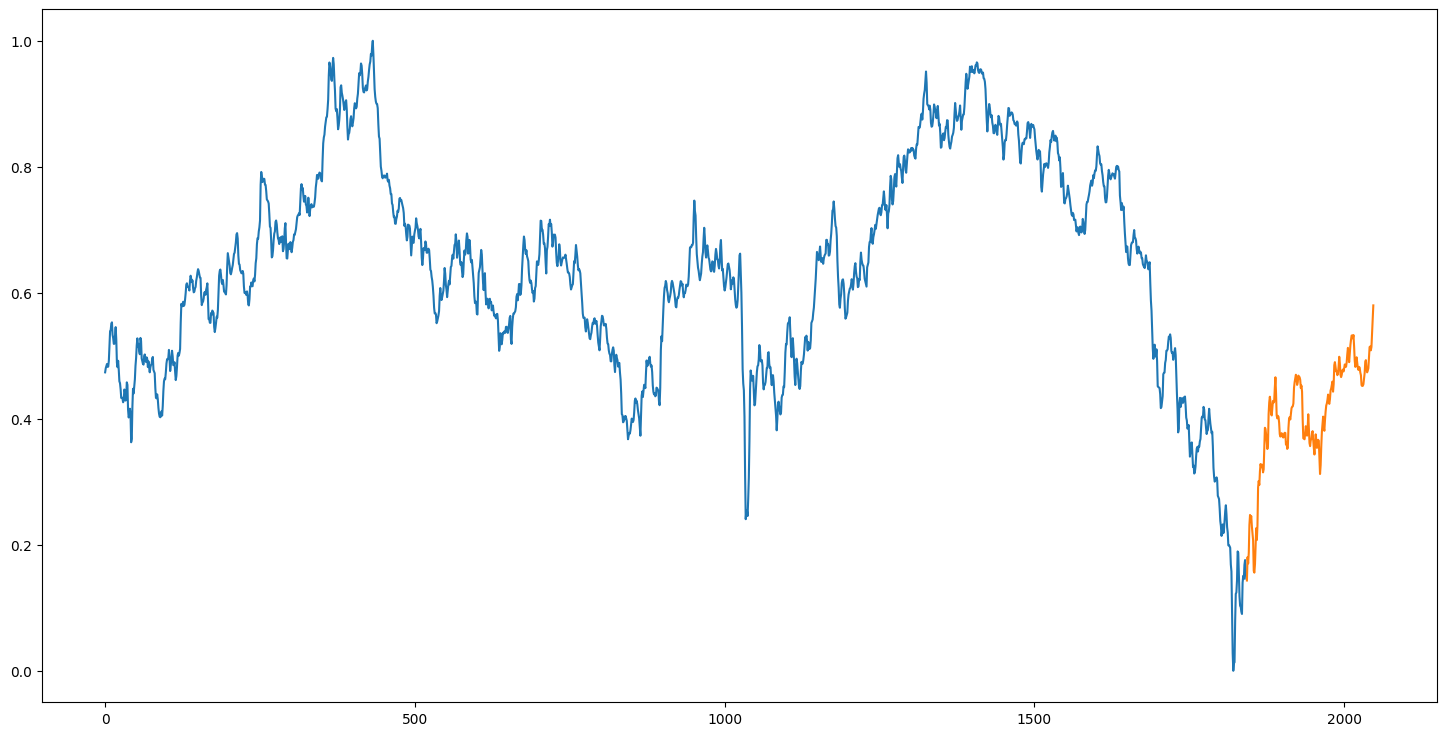

In [34]:
plt.figure(figsize=(18,9))
plt.plot(training_set_scaled)
plt.plot(test_set_plot)

time_step = 60

In [59]:
# create dataset technique t=t+1
for i in range(2,10):
    print(training_set_scaled[i-5:i,0])

[]
[]
[]
[0.47368821 0.48029119 0.48369629 0.48699088 0.48237707]
[0.48029119 0.48369629 0.48699088 0.48237707 0.48287437]
[0.48369629 0.48699088 0.48237707 0.48287437 0.49219176]
[0.48699088 0.48237707 0.48287437 0.49219176 0.51688389]
[0.48237707 0.48287437 0.49219176 0.51688389 0.53910335]


In [45]:
time_step = 60
def create_dataset(t_step, scaled_dataset):
    X_ = []
    y_ = []
    for i in range(t_step, scaled_dataset.shape[0]):
        X_.append(scaled_dataset[i-t_step:i, 0])
        y_.append(scaled_dataset[i, 0])

    X_, y_ = np.array(X_), np.array(y_)
    X = np.reshape(X_, (X_.shape[0], X_.shape[1], 1))
    return X, y_

In [43]:
X_train, y_train = create_dataset(time_step, training_set_scaled)
X_test, y_test = create_dataset(time_step, test_set_scaled)

In [60]:
print(X_train.shape, "\t", y_train.shape, "\n" ,X_test.shape, "\t", y_test.shape)

(1783, 60, 1) 	 (1783,) 
 (145, 60, 1) 	 (145,)


Make the necessary imports from keras

Add LSTM layer along with dropout layers to prevent overfitting. After that, we add a Dense layer that specifies a one unit output. Next, we compile the model using the adam optimizer and set the loss as the mean_squarred_error

In [63]:
model = Sequential()

model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=25,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=10))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])


In [108]:
epoch = 50

In [109]:
history = model.fit(X_train,y_train,epochs=epoch,batch_size=60, validation_split = 0.1)

Epoch 1/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0072 - accuracy: 6.2344e-04 - val_loss: 0.0050 - val_accuracy: 0.0056
Epoch 2/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0071 - accuracy: 6.2344e-04 - val_loss: 0.0048 - val_accuracy: 0.0056
Epoch 3/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0066 - accuracy: 6.2344e-04 - val_loss: 0.0051 - val_accuracy: 0.0056
Epoch 4/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0063 - accuracy: 6.2344e-04 - val_loss: 0.0043 - val_accuracy: 0.0056
Epoch 5/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0060 - accuracy: 6.2344e-04 - val_loss: 0.0061 - val_accuracy: 0.0056
Epoch 6/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0063 - accuracy: 6.2344e-04 - val_loss: 0.0051 - val_accuracy: 0.0056
Epoch 7/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0058 - accuracy: 6.2344e-04 - val_loss: 0.0041 - val_ac

In [100]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Import the test set for the model to make predictions on

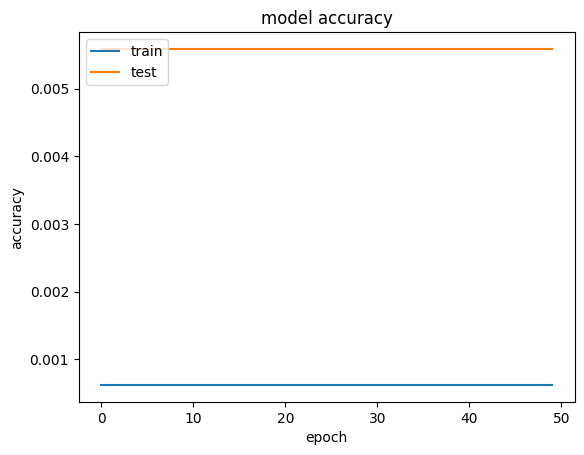

In [110]:

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


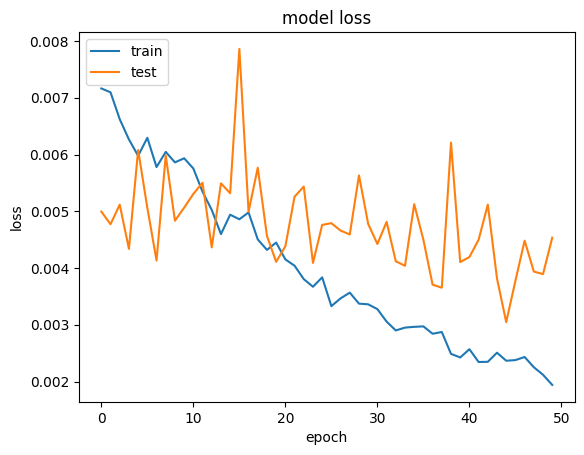

In [111]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

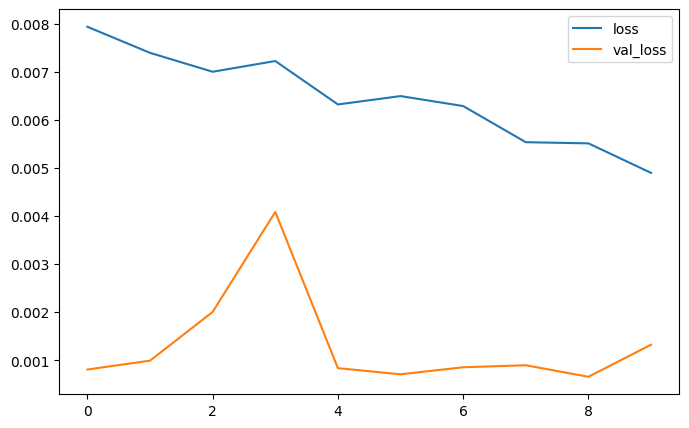

In [69]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/tatatest.csv'
dataset_test = pd.read_csv(url)
real_stock_price = dataset_test.iloc[:, 1:2].values

Before predicting future stock prices, we have to manipulate the training set; we merge the training set and the test set on the 0 axis, set the time step to 60, use minmaxscaler, and reshape the dataset as done previously. After making predictions, we use inverse_transform to get back the stock prices in normal readable format.


In [23]:
df

,Date,Time,Open,High,Low,Close,Volume,avg
0,2016.11.23,00:00,1.24212,1.24671,1.23587,1.24252,61588,1.241290
1,2016.11.24,00:00,1.24250,1.24928,1.24003,1.24497,53849,1.244655
2,2016.11.25,00:00,1.24494,1.24800,1.24139,1.24738,61200,1.244695
3,2016.11.27,00:00,1.24585,1.24799,1.24482,1.24782,1941,1.246405
4,2016.11.28,00:00,1.24781,1.25296,1.23839,1.24064,63375,1.245675
...,...,...,...,...,...,...,...,...
2043,2023.06.12,00:00,1.25792,1.25990,1.24864,1.25140,39154,1.254270
2044,2023.06.13,00:00,1.25139,1.26242,1.25128,1.26059,49789,1.256850
2045,2023.06.14,00:00,1.26058,1.26985,1.26001,1.26702,50186,1.264930
2046,2023.06.15,00:00,1.26703,1.27900,1.26291,1.27841,50135,1.270955


In [112]:
predicted_stock_2D = model.predict(X_test)

5/5 [==============================] - 0s 9ms/step


In [113]:
# predicted_stock_2D.shape
predicted_stock_price_plot = shift_plot(training_set_scaled, predicted_stock_2D)
y_test_plot = shift_plot(training_set_scaled, y_test.reshape(-1,1))
# y_test_plot.shape

In [106]:

print(total_dataset_scaled.shape, "\n", training_set_scaled.shape, "\n" ,test_set_scaled.shape)
print(X_train.shape, "\t", y_train.shape, "\n" ,X_test.shape, "\t", y_test.shape)
print(test_set_plot.shape, '\n', predicted_stock_price_plot.shape)

(2048, 1) 
 (1843, 1) 
 (205, 1)
(1783, 60, 1) 	 (1783,) 
 (145, 60, 1) 	 (145,)
(2048, 1) 
 (1988, 1)


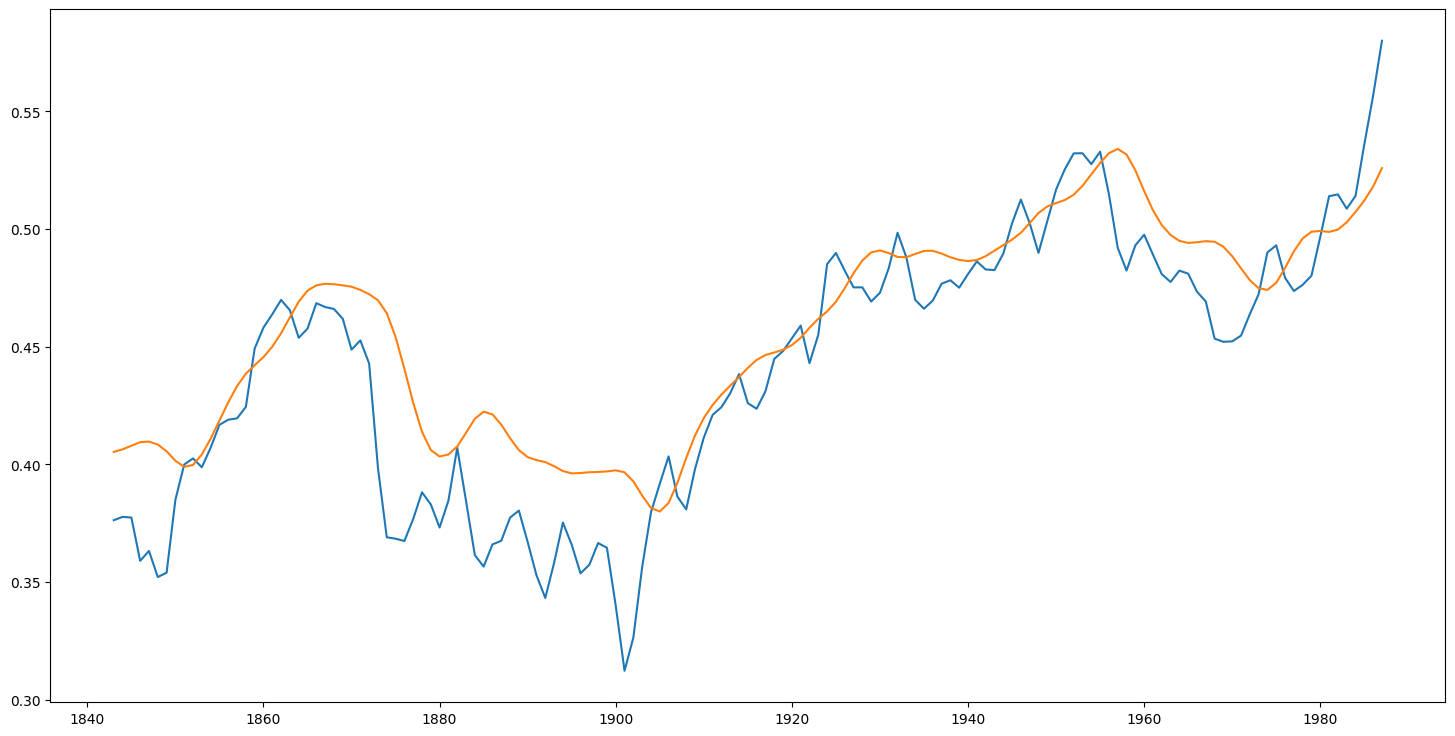

In [114]:
plt.figure(figsize=(18,9))
# plt.plot(training_set_scaled)
plt.plot(y_test_plot)
plt.plot(predicted_stock_price_plot)

Plot our predicted stock prices and the actual stock price